# Analysis of Airbnb prices in European cities

## Load and transform data

In [ ]:
#!pip install google-auth google-auth-oauthlib google-auth-httplib2 google-api-python-client pandas scipy folium

In [139]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind, ttest_rel, chi2_contingency

from google.oauth2 import service_account
from googleapiclient.discovery import build

import folium
from folium.plugins import MarkerCluster

# Set display option to show all columns
pd.set_option('display.max_columns', None)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Load all the data using API

In [4]:
# Google Sheets document URL and spreadsheet ID
spreadsheet_id = '1ecopK6oyyb4d_7-QLrCr8YlgFrCetHU7-VQfnYej7JY'

# Path to downloaded Service Account JSON file
json_key_file = 'banded-anvil-309310-3642b97f7801.json'

# Authenticate using OAuth 2.0 JSON file
creds = service_account.Credentials.from_service_account_file(
    json_key_file,
    scopes=["https://www.googleapis.com/auth/spreadsheets.readonly"]
)
service = build('sheets', 'v4', credentials=creds)

# Get the list of all sheets in the spreadsheet
spreadsheet = service.spreadsheets().get(spreadsheetId=spreadsheet_id).execute()
sheet_names = [sheet['properties']['title'] for sheet in spreadsheet['sheets']]

# Load each sheet and add city name and day type as columns
all_sheets = []
for sheet_name in sheet_names:
    # Fetch data from Google Sheets
    result = service.spreadsheets().values().get(spreadsheetId=spreadsheet_id, range=sheet_name).execute()
    values = result.get('values', [])
    
    if values:
        # Convert to DataFrame
        df = pd.DataFrame(values[1:], columns=values[0])  # Assuming first row as header

        # Drop the first column which contains the index
        df = df.drop(df.columns[0], axis=1)

        # Extract city name and day type from sheet name
        city_name, day_type = sheet_name.split('_')
        df['city'] = city_name.capitalize()
        df['day_type'] = day_type.capitalize()  # Capitalize to get 'Weekdays' or 'Weekend'

        # Append DataFrame to the list
        all_sheets.append(df)

# Combine all sheets into a single DataFrame
combined_df = pd.concat(all_sheets, ignore_index=True).reset_index(drop=True)

# Display the combined DataFrame
display(combined_df.head())

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,day_type
0,194.0336981,Private room,FALSE,TRUE,2,FALSE,1,0,10,93,1,5.022963798,2.539380003,78.69037927,4.166707868,98.25389587,6.846472824,4.90569,52.41772,Amsterdam,Weekdays
1,344.245776,Private room,FALSE,TRUE,4,FALSE,0,0,8,85,1,0.4883892888,0.2394039228,631.1763783,33.42120862,837.2807567,58.34292774,4.90005,52.37432,Amsterdam,Weekdays
2,264.1014224,Private room,FALSE,TRUE,2,FALSE,0,1,9,87,1,5.748311915,3.651621289,75.27587691,3.9859077,95.38695493,6.646700255,4.97512,52.36103,Amsterdam,Weekdays
3,433.529398,Private room,FALSE,TRUE,4,FALSE,0,1,9,90,2,0.3848620128,0.4398760761,493.2725344,26.11910845,875.0330976,60.97356517,4.89417,52.37663,Amsterdam,Weekdays
4,485.5529257,Private room,FALSE,TRUE,2,TRUE,0,0,10,98,1,0.5447381834,0.3186926468,552.8303244,29.272733,815.30574,56.81167696,4.90051,52.37508,Amsterdam,Weekdays


In [ ]:
# Get the names of the columns
combined_df.columns

Index(['realSum', 'room_type', 'room_shared', 'room_private',
       'person_capacity', 'host_is_superhost', 'multi', 'biz',
       'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms', 'dist',
       'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index',
       'rest_index_norm', 'lng', 'lat', 'city', 'day_type'],
      dtype='object')

In [6]:
# Convert specified columns to int64
int_columns = ['person_capacity', 'multi', 'biz', 'cleanliness_rating', 'guest_satisfaction_overall', 'bedrooms']
combined_df[int_columns] = combined_df[int_columns].astype('int64')

# Convert specified columns to float
float_columns = ['realSum', 'dist', 'metro_dist', 'attr_index', 'attr_index_norm', 'rest_index',
                 'rest_index_norm', 'lng', 'lat']
combined_df[float_columns] = combined_df[float_columns].astype('float64')

# Display the updated DataFrame and check dtypes
display(combined_df.head())

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,day_type
0,194.033698,Private room,FALSE,TRUE,2,FALSE,1,0,10,93,1,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,Amsterdam,Weekdays
1,344.245776,Private room,FALSE,TRUE,4,FALSE,0,0,8,85,1,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,Amsterdam,Weekdays
2,264.101422,Private room,FALSE,TRUE,2,FALSE,0,1,9,87,1,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,Amsterdam,Weekdays
3,433.529398,Private room,FALSE,TRUE,4,FALSE,0,1,9,90,2,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,Amsterdam,Weekdays
4,485.552926,Private room,FALSE,TRUE,2,TRUE,0,0,10,98,1,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,Amsterdam,Weekdays


In [7]:
# Get info about columns
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51707 entries, 0 to 51706
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   realSum                     51707 non-null  float64
 1   room_type                   51707 non-null  object 
 2   room_shared                 51707 non-null  object 
 3   room_private                51707 non-null  object 
 4   person_capacity             51707 non-null  int64  
 5   host_is_superhost           51707 non-null  object 
 6   multi                       51707 non-null  int64  
 7   biz                         51707 non-null  int64  
 8   cleanliness_rating          51707 non-null  int64  
 9   guest_satisfaction_overall  51707 non-null  int64  
 10  bedrooms                    51707 non-null  int64  
 11  dist                        51707 non-null  float64
 12  metro_dist                  51707 non-null  float64
 13  attr_index                  517

### Create column with countries and change the name of realSum to Price

In [8]:
# Get unique city names
combined_df['city'].unique()

array(['Amsterdam', 'Athens', 'Berlin', 'Barcelona', 'Budapest', 'Lisbon',
       'London', 'Paris', 'Rome', 'Vienna'], dtype=object)

In [9]:
# Define the mapping of cities to countries
city_to_country = {
    'Amsterdam': 'Netherlands',
    'Athens': 'Greece',
    'Berlin': 'Germany',
    'Barcelona': 'Spain',
    'Budapest': 'Hungary',
    'Lisbon': 'Portugal',
    'London': 'United Kingdom',
    'Paris': 'France',
    'Rome': 'Italy',
    'Vienna': 'Austria'
}

# Map the city column to the country column using the dictionary
combined_df['country'] = combined_df['city'].map(city_to_country)

# Change name of the column realSum to price
combined_df = combined_df.rename(columns={'realSum': 'price'})

combined_df.head()

,price,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,day_type,country
0,194.033698,Private room,FALSE,TRUE,2,FALSE,1,0,10,93,1,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,Amsterdam,Weekdays,Netherlands
1,344.245776,Private room,FALSE,TRUE,4,FALSE,0,0,8,85,1,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,Amsterdam,Weekdays,Netherlands
2,264.101422,Private room,FALSE,TRUE,2,FALSE,0,1,9,87,1,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,Amsterdam,Weekdays,Netherlands
3,433.529398,Private room,FALSE,TRUE,4,FALSE,0,1,9,90,2,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,Amsterdam,Weekdays,Netherlands
4,485.552926,Private room,FALSE,TRUE,2,TRUE,0,0,10,98,1,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,Amsterdam,Weekdays,Netherlands


### Instead of having two columns of room_shared and room_private, create one with the respective categories

In [10]:
# Drop duplicated column
combined_df = combined_df.drop(columns=['room_type'])

# Define conditions
conditions = [
    (combined_df['room_shared'] == 'TRUE'),
    (combined_df['room_private'] == 'TRUE') & (combined_df['room_shared'] == 'FALSE'),
    (combined_df['room_shared'] == 'FALSE') & (combined_df['room_private'] == 'FALSE')
]

# Define the corresponding choices for each condition
choices = ['Shared', 'Private', 'Entire Apt']

# Create the new column using np.select, with the default set to 'Unknown' or leave as NaN
combined_df['room_type'] = np.select(conditions, choices, default='Unknown')

# Drop the original room_shared and room_private columns if they are no longer needed
combined_df = combined_df.drop(columns=['room_shared', 'room_private'])

# Display the updated DataFrame
display(combined_df.head())

,price,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,day_type,country,room_type
0,194.033698,2,FALSE,1,0,10,93,1,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,Amsterdam,Weekdays,Netherlands,Private
1,344.245776,4,FALSE,0,0,8,85,1,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,Amsterdam,Weekdays,Netherlands,Private
2,264.101422,2,FALSE,0,1,9,87,1,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,Amsterdam,Weekdays,Netherlands,Private
3,433.529398,4,FALSE,0,1,9,90,2,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,Amsterdam,Weekdays,Netherlands,Private
4,485.552926,2,TRUE,0,0,10,98,1,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,Amsterdam,Weekdays,Netherlands,Private


### Convert 'TRUE' to 1 and 'FALSE' to 0 in the host_is_superhost column

In [11]:
# Convert 'TRUE' to 1 and 'FALSE' to 0 in the host_is_superhost column
combined_df['host_is_superhost'] = combined_df['host_is_superhost'].replace({'TRUE': 1, 'FALSE': 0})

# Display the updated DataFrame to verify
display(combined_df.head())

,price,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,day_type,country,room_type
0,194.033698,2,0,1,0,10,93,1,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,Amsterdam,Weekdays,Netherlands,Private
1,344.245776,4,0,0,0,8,85,1,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,Amsterdam,Weekdays,Netherlands,Private
2,264.101422,2,0,0,1,9,87,1,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,Amsterdam,Weekdays,Netherlands,Private
3,433.529398,4,0,0,1,9,90,2,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,Amsterdam,Weekdays,Netherlands,Private
4,485.552926,2,1,0,0,10,98,1,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,Amsterdam,Weekdays,Netherlands,Private


### Instead of dummy variables, create a column where one can know if the host of the listing has only one, two, four, and more than four listings

In [12]:
# Define conditions
conditions = [
    (combined_df['multi'] == 0) & (combined_df['biz'] == 0),  # Single listing
    (combined_df['multi'] == 1) & (combined_df['biz'] == 0),  # Multiple (2-4) listings but not business
    (combined_df['biz'] == 1)  # Business, more than four listings
]

# Define the corresponding choices for each condition
choices = ['Single', 'Few', 'Many']

# Create the new column using np.select, with the default set to 'Unknown' or leave as NaN
combined_df['listing_num'] = np.select(conditions, choices, default='Unknown')

# Drop the original room_shared and room_private columns if they are no longer needed
combined_df = combined_df.drop(columns=['multi', 'biz'])

# Display the updated DataFrame
display(combined_df.head())

,price,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,day_type,country,room_type,listing_num
0,194.033698,2,0,10,93,1,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,Amsterdam,Weekdays,Netherlands,Private,Few
1,344.245776,4,0,8,85,1,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,Amsterdam,Weekdays,Netherlands,Private,Single
2,264.101422,2,0,9,87,1,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,Amsterdam,Weekdays,Netherlands,Private,Many
3,433.529398,4,0,9,90,2,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,Amsterdam,Weekdays,Netherlands,Private,Many
4,485.552926,2,1,10,98,1,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,Amsterdam,Weekdays,Netherlands,Private,Single


In [13]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51707 entries, 0 to 51706
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   price                       51707 non-null  float64
 1   person_capacity             51707 non-null  int64  
 2   host_is_superhost           51707 non-null  int64  
 3   cleanliness_rating          51707 non-null  int64  
 4   guest_satisfaction_overall  51707 non-null  int64  
 5   bedrooms                    51707 non-null  int64  
 6   dist                        51707 non-null  float64
 7   metro_dist                  51707 non-null  float64
 8   attr_index                  51707 non-null  float64
 9   attr_index_norm             51707 non-null  float64
 10  rest_index                  51707 non-null  float64
 11  rest_index_norm             51707 non-null  float64
 12  lng                         51707 non-null  float64
 13  lat                         517

In [15]:
combined_df.describe()

,price,person_capacity,host_is_superhost,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
count,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.00000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000,51707.000000
mean,279.879591,3.161661,0.255903,9.390624,92.628232,1.15876,3.191285,0.681540,294.204105,13.423792,626.856696,22.786177,7.426068,45.671128
std,327.948386,1.298545,0.436372,0.954868,8.945531,0.62741,2.393803,0.858023,224.754123,9.807985,497.920226,17.804096,9.799725,5.249263
min,34.779339,2.000000,0.000000,2.000000,20.000000,0.00000,0.015045,0.002301,15.152201,0.926301,19.576924,0.592757,-9.226340,37.953000
25%,148.752174,2.000000,0.000000,9.000000,90.000000,1.00000,1.453142,0.248480,136.797385,6.380926,250.854114,8.751480,-0.072500,41.399510
50%,211.343089,3.000000,0.000000,10.000000,95.000000,1.00000,2.613538,0.413269,234.331748,11.468305,522.052783,17.542238,4.873000,47.506690
75%,319.694286,4.000000,1.000000,10.000000,99.000000,1.00000,4.263077,0.737840,385.756381,17.415082,832.628988,32.964603,13.518825,51.471885
max,18545.450280,6.000000,1.000000,10.000000,100.000000,10.00000,25.284557,14.273577,4513.563486,100.000000,6696.156772,100.000000,23.786020,52.641410


Data transformation is complete.

## EDA

### Function to create graphs

In [162]:
# Adjust the plot_bar_chart function to allow control over figure size and right spacing
def plot_bar_chart(data, x_col, y_col, title, xlabel, ylabel, palette="viridis", x_offset=30, frame_offset=1, fig_width=8, fig_height=6):
    """
    Plots a horizontal bar chart with the given data, column names, labels, and colors.
    
    Parameters:
    - data: DataFrame containing the data to plot.
    - x_col: Name of the column for the x-axis values.
    - y_col: Name of the column for the y-axis values.
    - title: Title of the plot.
    - xlabel: Label for the x-axis.
    - ylabel: Label for the y-axis.
    - palette: Color palette for the bars.
    - x_offset: Horizontal offset for the labels at the end of each bar.
    - fig_width: Width of the figure.
    - fig_height: Height of the figure.
    """
    plt.figure(figsize=(fig_width, fig_height))
    ax = sns.barplot(data=data, x=x_col, y=y_col, palette=palette)
    plt.title(title, fontsize=15, fontweight='bold')
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)

    # Increase the font size of the y-axis labels
    plt.yticks(fontsize=12)

    # Add labels at the end of each bar with a specified offset
    for index, value in enumerate(data[x_col]):
        ax.text(value + x_offset, index, str(value), va='center', ha='left', color='black', fontsize=12)

    # Увеличить предел оси x, чтобы создать больше пространства справа
    ax.set_xlim(0, data[x_col].max() * frame_offset) 

    plt.show()

1. How many listings are in each city in total and also per type of day?

Total listings per city:


,city,total_listings
0,London,9993
1,Rome,9027
2,Paris,6688
3,Lisbon,5763
4,Athens,5280
5,Budapest,4022
6,Vienna,3537
7,Barcelona,2833
8,Berlin,2484
9,Amsterdam,2080



Listings per city and type of day:


,city,day_type,listings_count
0,Amsterdam,Weekdays,1103
1,Amsterdam,Weekends,977
2,Athens,Weekdays,2653
3,Athens,Weekends,2627
4,Barcelona,Weekdays,1555
5,Barcelona,Weekends,1278
6,Berlin,Weekdays,1284
7,Berlin,Weekends,1200
8,Budapest,Weekdays,2074
9,Budapest,Weekends,1948


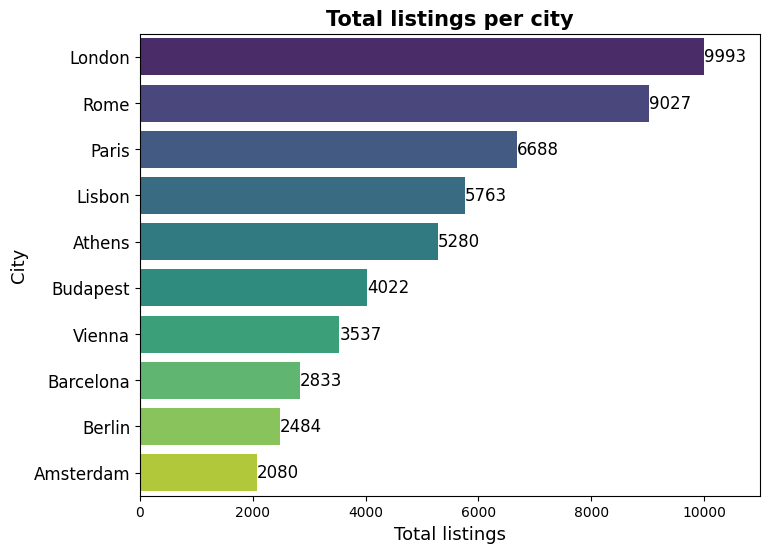

In [164]:
# Total listings per city
total_listings_per_city = combined_df.groupby('city').size().reset_index(name='total_listings').sort_values(by='total_listings', ascending=False).reset_index(drop=True)
print("Total listings per city:")
display(total_listings_per_city)

# Listings per city and type of day
listings_per_city_day_type = combined_df.groupby(['city', 'day_type']).size().reset_index(name='listings_count')
print("\nListings per city and type of day:")
display(listings_per_city_day_type)

# Plot the superhost proportion for each city
plot_bar_chart(
    data=total_listings_per_city,
    x_col='total_listings',
    y_col='city',
    title="Total listings per city",
    xlabel="Total listings",
    ylabel="City",
    palette="viridis",  # Change this to any palette you like
    x_offset=0.1,
    frame_offset=1.1
)

2. Which city has the biggest proportion of superhosts?

City with the highest proportion of superhosts:


,city,superhost_count,total_count,superhost_proportion
0,Athens,2263,5280,42.86
1,Budapest,1524,4022,37.89
2,Rome,2949,9027,32.67
3,Amsterdam,591,2080,28.41
4,Vienna,1005,3537,28.41
5,Berlin,639,2484,25.72
6,Lisbon,1233,5763,21.40
7,Barcelona,514,2833,18.14
8,London,1573,9993,15.74
9,Paris,941,6688,14.07


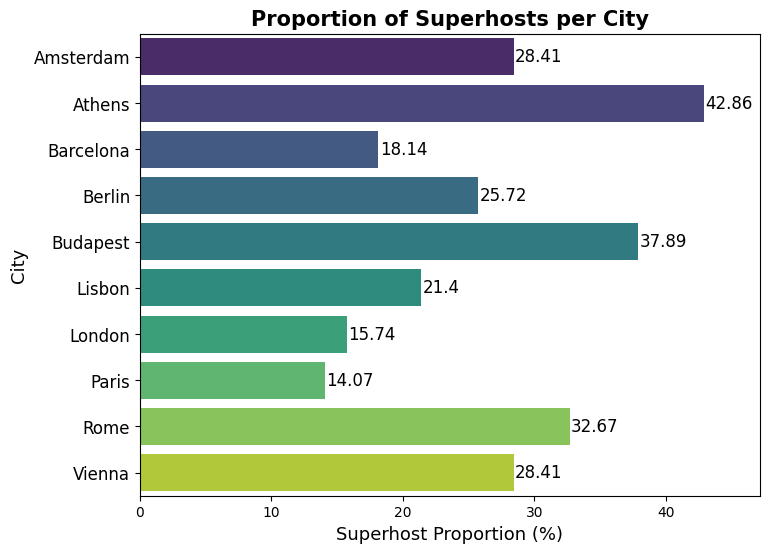

In [163]:
# Count the number of superhosts per city
superhost_counts = combined_df[combined_df['host_is_superhost'] == 1].groupby('city').size().reset_index(name='superhost_count')

# Count the total listings per city
total_counts = combined_df.groupby('city').size().reset_index(name='total_count')

# Merge the two DataFrames on 'city' to get both superhost and total counts
city_superhost_proportion = superhost_counts.merge(total_counts, on='city')

# Calculate the proportion of superhosts and format as percentage
city_superhost_proportion['superhost_proportion'] = (city_superhost_proportion['superhost_count'] / city_superhost_proportion['total_count'] * 100).round(2)

# Find the city with the highest proportion of superhosts
highest_superhost_city = city_superhost_proportion.sort_values(by='superhost_proportion', ascending=False).reset_index(drop=True)

print("City with the highest proportion of superhosts:")
display(highest_superhost_city)

# Plot the superhost proportion for each city
plot_bar_chart(
    data=city_superhost_proportion,
    x_col='superhost_proportion',
    y_col='city',
    title="Proportion of Superhosts per City",
    xlabel="Superhost Proportion (%)",
    ylabel="City",
    palette="viridis",  # Change this to any palette you like
    x_offset=0.1,
    frame_offset=1.1
)

Athens has the highest proportion of superhosts.

3. Which cities have listings with more than four rooms?

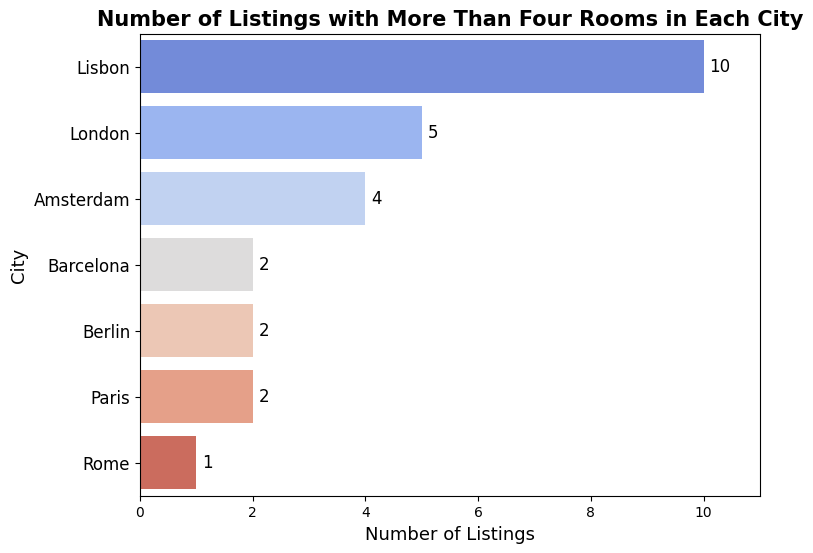

In [155]:
# Filter for listings with more than four rooms
listings_more_than_four_rooms = combined_df[combined_df['bedrooms'] > 4]

# Count the listings with more than four rooms per city
cities_with_more_than_four_rooms_count = listings_more_than_four_rooms.groupby('city').size().reset_index(name='count').sort_values(by='count', ascending=False).reset_index(drop=True)

# Plot the results
plot_bar_chart(
    data=cities_with_more_than_four_rooms_count,
    x_col='count',
    y_col='city',
    title="Number of Listings with More Than Four Rooms in Each City",
    xlabel="Number of Listings",
    ylabel="City",
    palette="coolwarm",  # Change this to any palette you like
    x_offset=0.1,
    frame_offset=1.1
)

Lisbon has the most number of listings with four rooms.

4. Which city has the most entire home/apt type listings?

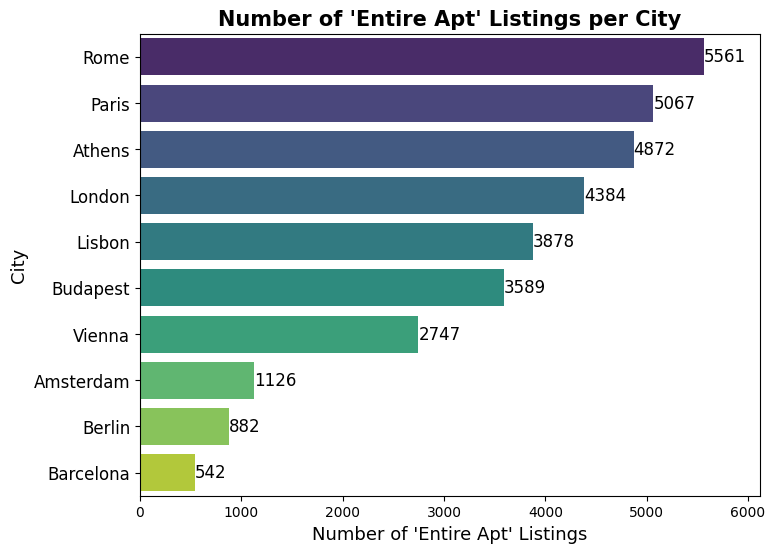

In [156]:
# Filter for "Entire Apt" listings
entire_home_listings = combined_df[combined_df['room_type'] == 'Entire Apt']

# Count the "Entire Apt" listings per city
entire_home_count_per_city = entire_home_listings.groupby('city').size().reset_index(name='entire_home_count')

# Sort the DataFrame by count in descending order for a cleaner plot
entire_home_count_per_city = entire_home_count_per_city.sort_values(by='entire_home_count', ascending=False)

# Plot the results
plot_bar_chart(
    data=entire_home_count_per_city,
    x_col='entire_home_count',
    y_col='city',
    title="Number of 'Entire Apt' Listings per City",
    xlabel="Number of 'Entire Apt' Listings",
    ylabel="City",
    palette="viridis",  # Change this to any palette you like
    x_offset=0.1,
    frame_offset=1.1
)

Rome has the highest number of Entire Apartments.

6. How does person_capacity vary across listings? What is the most common capacity of listings?

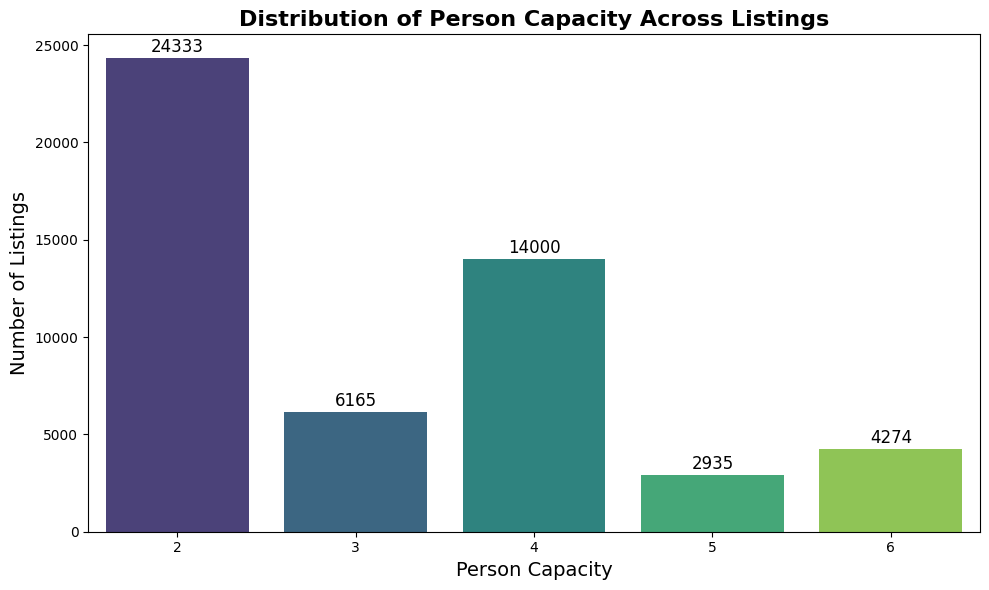

The most common person capacity is 2 with 24333 listings.


In [176]:
# Count occurrences of each person capacity
person_capacity_counts = combined_df['person_capacity'].value_counts().sort_index()

# Convert to DataFrame for compatibility with plot_bar_chart
person_capacity_df = person_capacity_counts.reset_index()
person_capacity_df.columns = ['person_capacity', 'count']

# Plot the distribution of person capacity
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=person_capacity_df, x='person_capacity', y='count', palette='viridis')
plt.title("Distribution of Person Capacity Across Listings", fontsize=16, fontweight='bold')
plt.xlabel("Person Capacity", fontsize=14)
plt.ylabel("Number of Listings", fontsize=14)

# Increase the fixed offset for the labels
fixed_offset = 500  # Adjust this value as needed

# Add count values on top of the bars with precise positioning
for bar in ax.patches:
    # Get the height of the bar for positioning the label
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 100,  # Adjust the offset as needed
            f'{int(height)}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

# Find the most common person capacity
most_common_capacity = person_capacity_df.loc[person_capacity_df['count'].idxmax()]
print(f"The most common person capacity is {most_common_capacity['person_capacity']} with {most_common_capacity['count']} listings.")

7. Plot the distribution of realSum for both weekday and weekend offers. Is it normally distributed, skewed, or multimodal? If skewed, consider using transformations (e.g., log transformation) to normalize it.

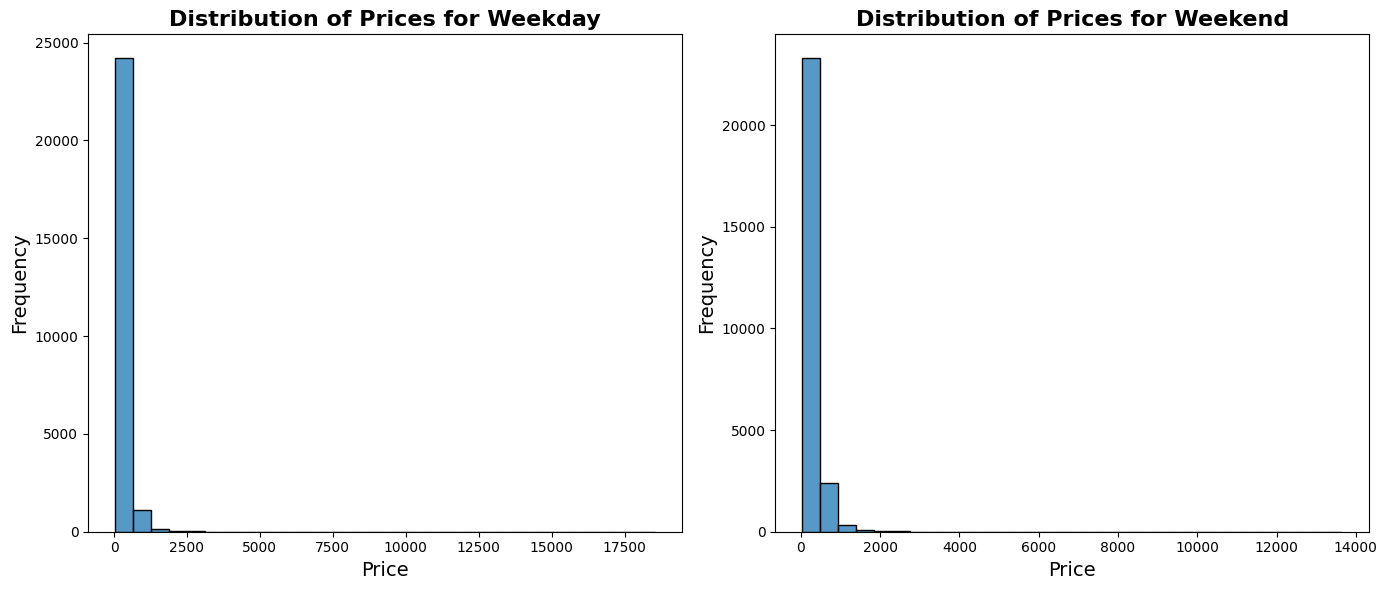

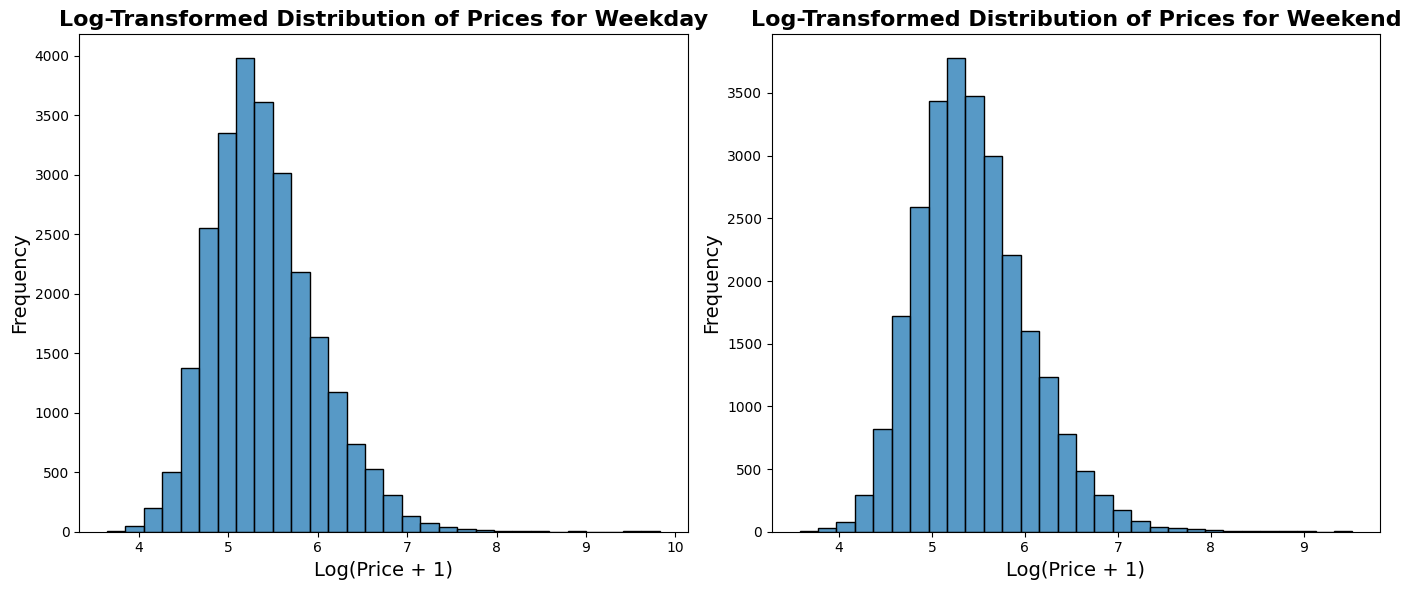

In [130]:
# Separate weekday and weekend prices
weekday_prices = combined_df[combined_df['day_type'] == 'Weekdays']['price']
weekend_prices = combined_df[combined_df['day_type'] == 'Weekends']['price']

# Plot distributions of prices for weekday and weekend offers
plt.figure(figsize=(14, 6))

# Weekday price distribution
plt.subplot(1, 2, 1)
sns.histplot(weekday_prices, bins=30)
plt.title("Distribution of Prices for Weekday", fontsize=16, fontweight='bold')
plt.xlabel("Price", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Weekend price distribution
plt.subplot(1, 2, 2)
sns.histplot(weekend_prices, bins=30)
plt.title("Distribution of Prices for Weekend", fontsize=16, fontweight='bold')
plt.xlabel("Price", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

plt.tight_layout()
plt.show()

# Apply Log Transformation if distributions are skewed
# Only apply log where prices are non-zero to avoid log(0) errors
weekday_prices_log = np.log1p(weekday_prices)  # log1p is log(1 + x) to handle 0 values
weekend_prices_log = np.log1p(weekend_prices)

# Plot transformed distributions
plt.figure(figsize=(14, 6))

# Weekday price distribution after log transformation
plt.subplot(1, 2, 1)
sns.histplot(weekday_prices_log, bins=30)
plt.title("Log-Transformed Distribution of Prices for Weekday", fontsize=16, fontweight='bold')
plt.xlabel("Log(Price + 1)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Weekend price distribution after log transformation
plt.subplot(1, 2, 2)
sns.histplot(weekend_prices_log, bins=30)
plt.title("Log-Transformed Distribution of Prices for Weekend", fontsize=16, fontweight='bold')
plt.xlabel("Log(Price + 1)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

plt.tight_layout()
plt.show()

The prices are skewed both on the weekends and weekdays, so we used log transformation.

8. Plot the distribution of guest_satisfaction_overall ratings. 

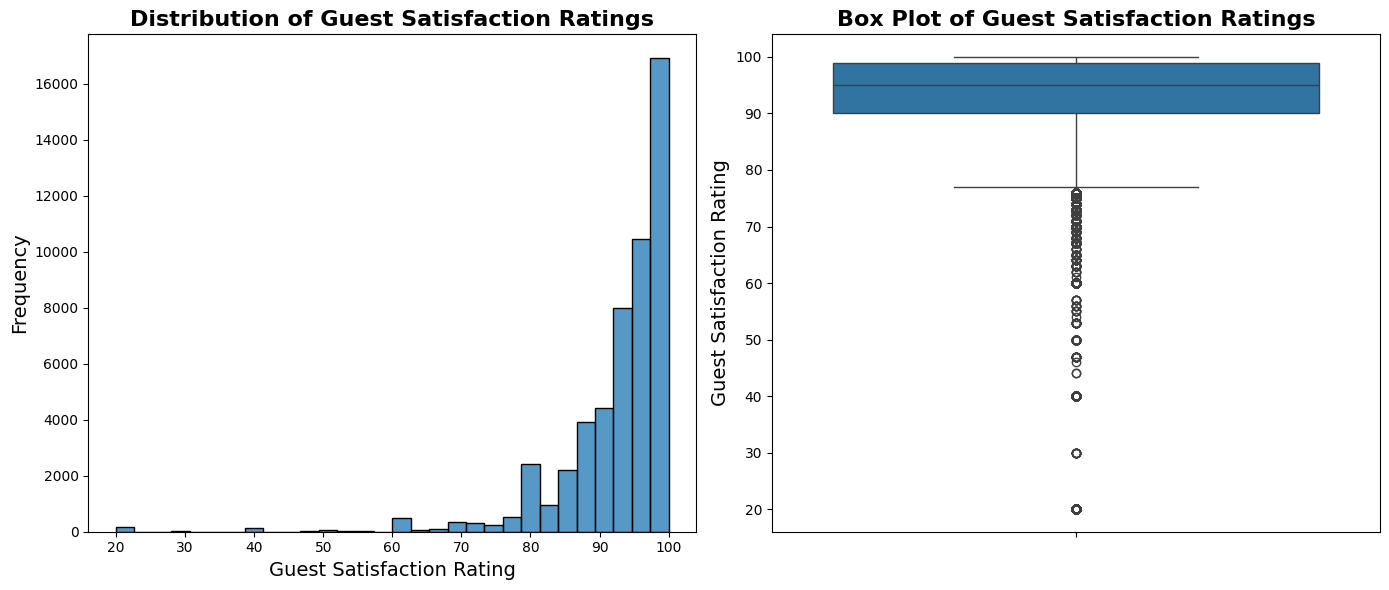

In [150]:
# Extract the guest satisfaction ratings column
guest_satisfaction_ratings = combined_df['guest_satisfaction_overall']

# Set up the figure with two subplots (1 row, 2 columns)
plt.figure(figsize=(14, 6))

# Histogram subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.histplot(guest_satisfaction_ratings, bins=30, edgecolor="black")
plt.title("Distribution of Guest Satisfaction Ratings", fontsize=16, fontweight='bold')
plt.xlabel("Guest Satisfaction Rating", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Boxplot subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.boxplot(y=guest_satisfaction_ratings)
plt.title("Box Plot of Guest Satisfaction Ratings", fontsize=16, fontweight='bold')
plt.ylabel("Guest Satisfaction Rating", fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

The guest satisfaction is skewed towards positive ratings.

9. Examine the distribution of cleanliness_rating.

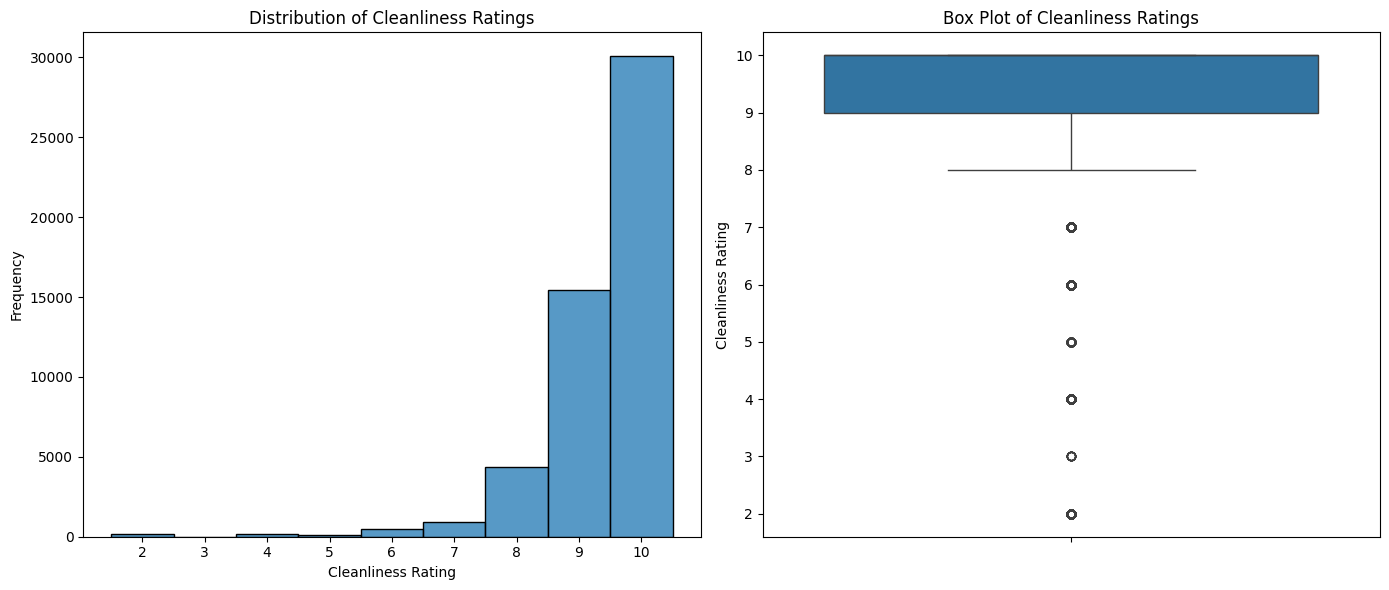

In [149]:
# Define the cleanliness ratings column
cleanliness_ratings = combined_df['cleanliness_rating']

# Set up the figure with two subplots (1 row, 2 columns)
plt.figure(figsize=(14, 6))

# Histogram subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.histplot(cleanliness_ratings, bins=np.arange(1.5, 11.5, 1), edgecolor="black")
plt.title("Distribution of Cleanliness Ratings")
plt.xlabel("Cleanliness Rating")
plt.ylabel("Frequency")
plt.xticks(np.arange(2, 11, 1))  # Set x-ticks to integer values

# Boxplot subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.boxplot(y=cleanliness_ratings)
plt.title("Box Plot of Cleanliness Ratings")
plt.ylabel("Cleanliness Rating")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

It is more skewed towards Ratings 9 and 10.

## Testing

1.	Is there a difference in price between two cities? Choose at least three pairs of cities during weekdays.

Comparing Paris and London (Weekdays):
  T-test Results: t-statistic=3.57, p-value=0.000355
  Conclusion: Significant difference in price.
--------------------------------------------------


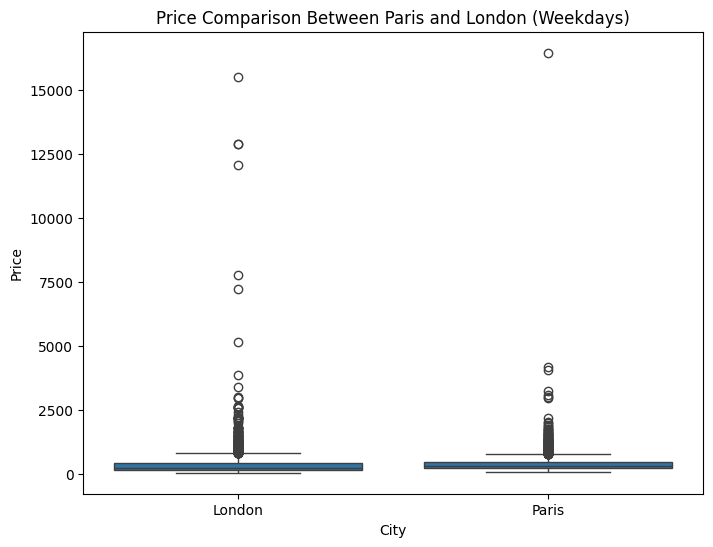

Comparing Rome and Berlin (Weekdays):
  T-test Results: t-statistic=-8.12, p-value=0.000000
  Conclusion: Significant difference in price.
--------------------------------------------------


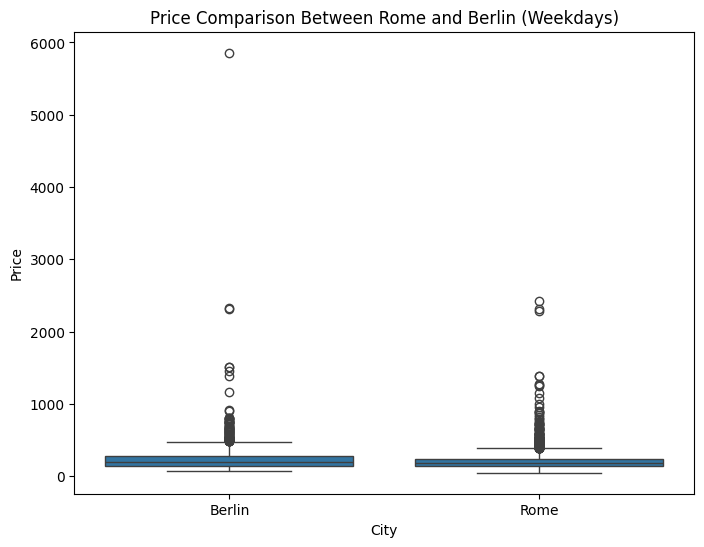

Comparing Athens and Lisbon (Weekdays):
  T-test Results: t-statistic=-11.22, p-value=0.000000
  Conclusion: Significant difference in price.
--------------------------------------------------


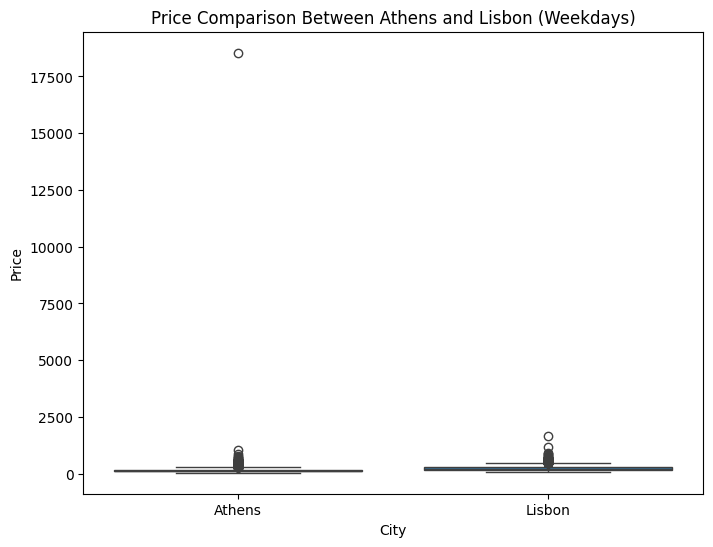

In [144]:
# Define the city pairs to compare
city_pairs = [('Paris', 'London'), ('Rome', 'Berlin'), ('Athens', 'Lisbon')]

# Loop over each pair, perform a t-test, and plot the results
for city1, city2 in city_pairs:
    # Filter prices for each city during weekdays
    city1_prices = combined_df[(combined_df['city'] == city1) & (combined_df['day_type'] == 'Weekdays')]['price']
    city2_prices = combined_df[(combined_df['city'] == city2) & (combined_df['day_type'] == 'Weekdays')]['price']
    
    # Perform t-test to see if there's a significant difference in prices
    t_stat, p_value = ttest_ind(city1_prices, city2_prices, nan_policy='omit')
    print(f"Comparing {city1} and {city2} (Weekdays):")
    print(f"  T-test Results: t-statistic={t_stat:.2f}, p-value={p_value:.6f}")
    if p_value < 0.05:
        print("  Conclusion: Significant difference in price.")
    else:
        print("  Conclusion: No significant difference in price.")
    print("-" * 50)
    
    # Plot box plots to visually compare prices between the two cities
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=combined_df[combined_df['city'].isin([city1, city2]) & (combined_df['day_type'] == 'Weekdays')],
                x='city', y='price')
    plt.title(f"Price Comparison Between {city1} and {city2} (Weekdays)")
    plt.ylabel("Price")
    plt.xlabel("City")
    plt.show()

2.	Does the price tend to be higher on weekends?

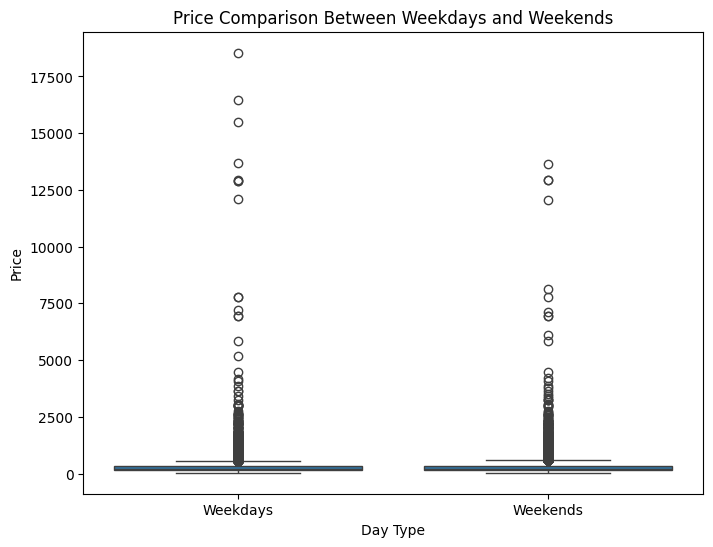

T-test Results: t-statistic=-2.8712504245461883, p-value=0.004090175032990993
  Conclusion: Significant difference in price.


In [148]:
# Filter data by weekday and weekend prices
weekday_prices = combined_df[combined_df['day_type'] == 'Weekdays']['price']
weekend_prices = combined_df[combined_df['day_type'] == 'Weekends']['price']

# Plot box plots for weekday and weekend prices
plt.figure(figsize=(8, 6))
sns.boxplot(data=combined_df, x='day_type', y='price')
plt.title("Price Comparison Between Weekdays and Weekends")
plt.ylabel("Price")
plt.xlabel("Day Type")
plt.show()

# Perform t-test (paired if prices are for same listings)
t_stat, p_value = ttest_ind(weekday_prices, weekend_prices, nan_policy='omit')
print(f"T-test Results: t-statistic={t_stat}, p-value={p_value}")
if p_value < 0.05:
    print("  Conclusion: Significant difference in price.")
else:
    print("  Conclusion: No significant difference in price.")

3.	Are listings of superhosts more expensive than those of normal hosts?

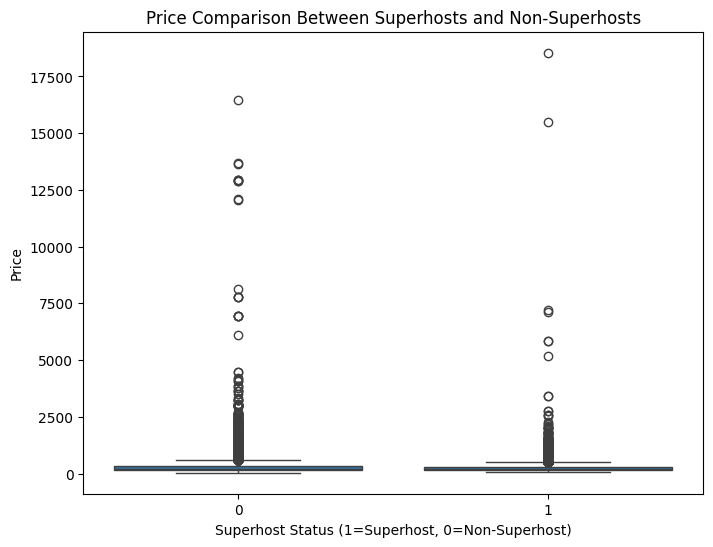

T-test Results: t-statistic=-10.351807658508509, p-value=4.345180844885508e-25


In [177]:
# Filter prices by superhost status
superhost_prices = combined_df[combined_df['host_is_superhost'] == 1]['price']
non_superhost_prices = combined_df[combined_df['host_is_superhost'] == 0]['price']

# Plot prices for superhosts and non-superhosts
plt.figure(figsize=(8, 6))
sns.boxplot(data=combined_df, x='host_is_superhost', y='price')
plt.title("Price Comparison Between Superhosts and Non-Superhosts")
plt.xlabel("Superhost Status (1=Superhost, 0=Non-Superhost)")
plt.ylabel("Price")
plt.show()

# Perform t-test
t_stat, p_value = ttest_ind(superhost_prices, non_superhost_prices, nan_policy='omit')
print(f"T-test Results: t-statistic={t_stat}, p-value={p_value}")

4.	Are superhosts closer to the city center and metro station than normal hosts?

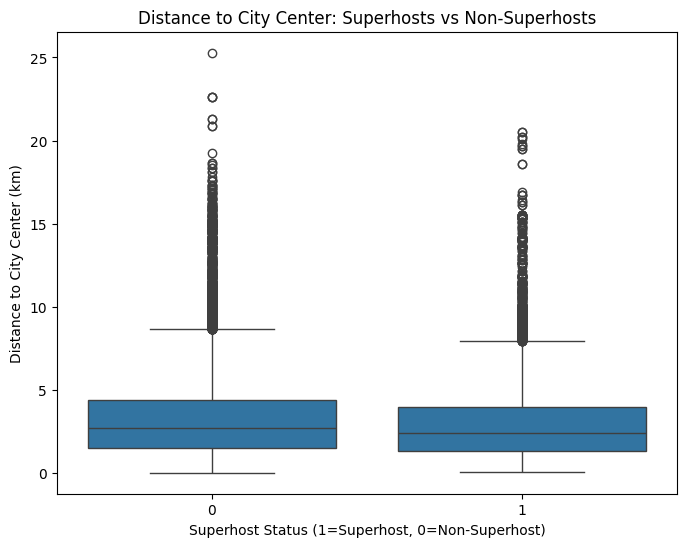

T-test Results: t-statistic=-12.779476066869789, p-value=2.4320703870842705e-37


In [178]:
# Filter distances by superhost status
superhost_dist = combined_df[combined_df['host_is_superhost'] == 1]['dist']
non_superhost_dist = combined_df[combined_df['host_is_superhost'] == 0]['dist']

# Plot distances for superhosts and non-superhosts
plt.figure(figsize=(8, 6))
sns.boxplot(data=combined_df, x='host_is_superhost', y='dist')
plt.title("Distance to City Center: Superhosts vs Non-Superhosts")
plt.xlabel("Superhost Status (1=Superhost, 0=Non-Superhost)")
plt.ylabel("Distance to City Center (km)")
plt.show()

# Perform t-test
t_stat, p_value = ttest_ind(superhost_dist, non_superhost_dist, nan_policy='omit')
print(f"T-test Results: t-statistic={t_stat}, p-value={p_value}")

5.	Are superhosts cleaner than normal hosts?

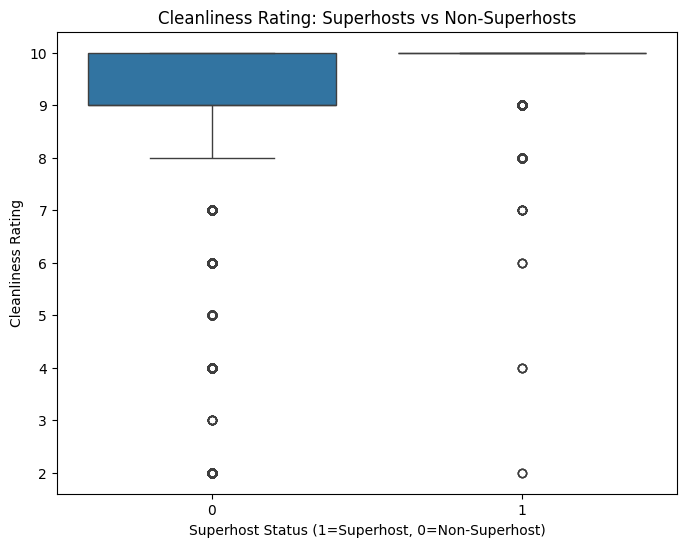

T-test Results: t-statistic=64.36845073256731, p-value=0.0


In [179]:
# Filter cleanliness ratings by superhost status
superhost_cleanliness = combined_df[combined_df['host_is_superhost'] == 1]['cleanliness_rating']
non_superhost_cleanliness = combined_df[combined_df['host_is_superhost'] == 0]['cleanliness_rating']

# Plot cleanliness ratings
plt.figure(figsize=(8, 6))
sns.boxplot(data=combined_df, x='host_is_superhost', y='cleanliness_rating')
plt.title("Cleanliness Rating: Superhosts vs Non-Superhosts")
plt.xlabel("Superhost Status (1=Superhost, 0=Non-Superhost)")
plt.ylabel("Cleanliness Rating")
plt.show()

# Perform t-test
t_stat, p_value = ttest_ind(superhost_cleanliness, non_superhost_cleanliness, nan_policy='omit')
print(f"T-test Results: t-statistic={t_stat}, p-value={p_value}")

6.	Is there a pattern between room types and superhost status?

Chi-Square Test Results: chi2=176.54066965543066, p-value=4.620411632426391e-39


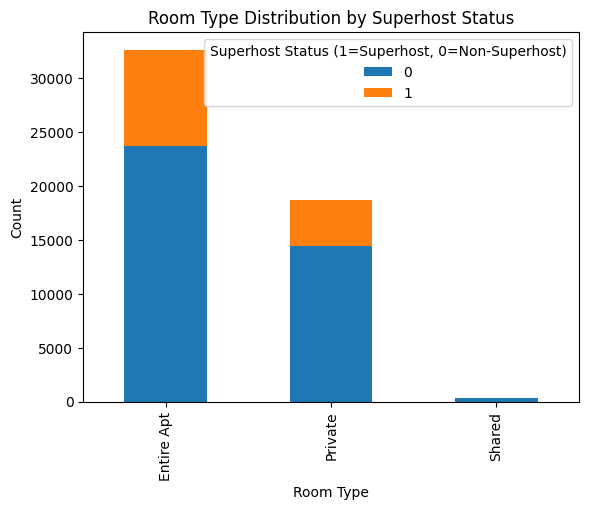

In [180]:
from scipy.stats import chi2_contingency

# Create a contingency table
room_type_superhost_table = pd.crosstab(combined_df['room_type'], combined_df['host_is_superhost'])

# Perform chi-square test of independence
chi2, p, dof, expected = chi2_contingency(room_type_superhost_table)
print(f"Chi-Square Test Results: chi2={chi2}, p-value={p}")

# Plot the stacked bar chart
room_type_superhost_table.plot(kind="bar", stacked=True)
plt.title("Room Type Distribution by Superhost Status")
plt.xlabel("Room Type")
plt.ylabel("Count")
plt.legend(title="Superhost Status (1=Superhost, 0=Non-Superhost)")
plt.show()

7.	Is it more expensive to rent an entire home/apt than a private room? Does that depend on the city?

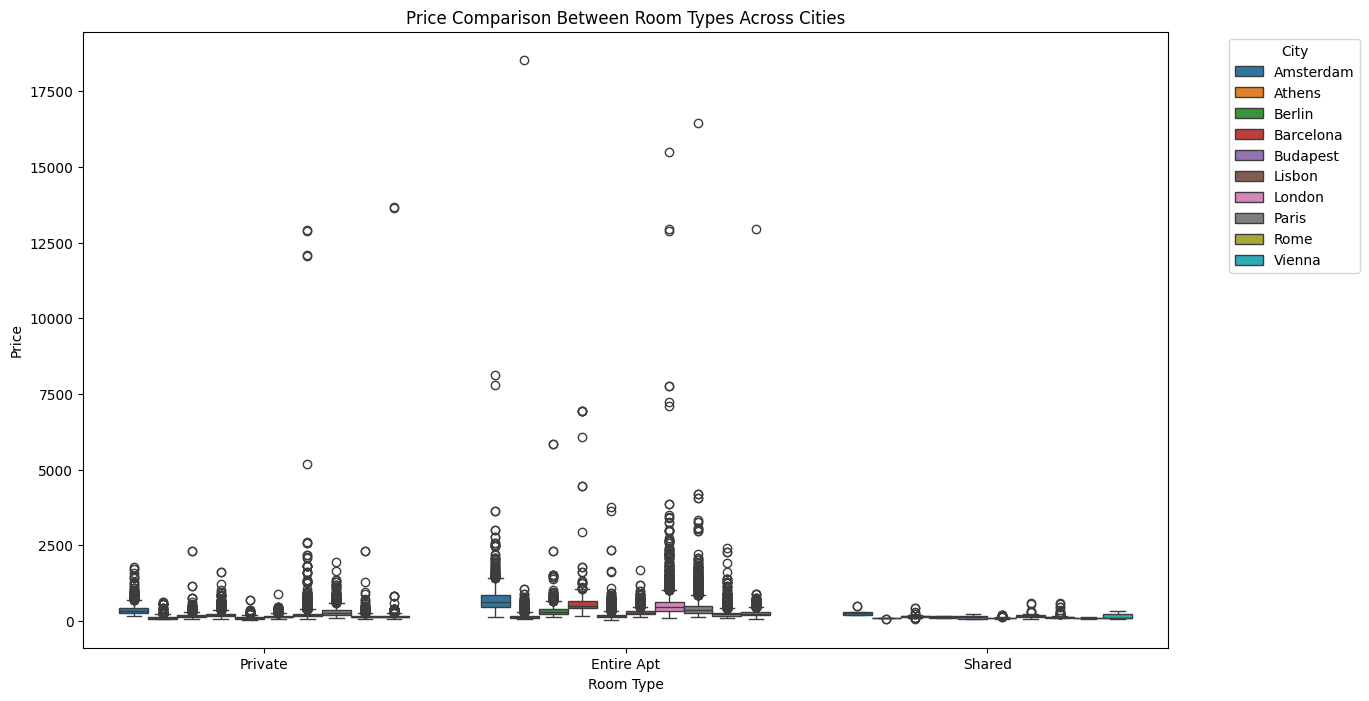

In [181]:
# Plot box plots to compare prices by room type and city
plt.figure(figsize=(14, 8))
sns.boxplot(data=combined_df, x='room_type', y='price', hue='city')
plt.title("Price Comparison Between Room Types Across Cities")
plt.xlabel("Room Type")
plt.ylabel("Price")
plt.legend(title="City", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

8.	Create a map for each city where the top 10 most expensive Airbnbs are shown and the top 10 cheapest Airbnbs are shown.

In [183]:
# Define a function to plot the map for a specific city
def plot_price_map(city_name):
    # Filter listings for the specific city
    city_data = combined_df[combined_df['city'] == city_name]
    
    # Get top 10 most expensive and cheapest listings
    top_10_expensive = city_data.nlargest(10, 'price')
    top_10_cheap = city_data.nsmallest(10, 'price')

    # Initialize map centered around the city
    city_center = [city_data['lat'].mean(), city_data['lng'].mean()]
    city_map = folium.Map(location=city_center, zoom_start=12)

    # Add expensive listings to the map
    for _, row in top_10_expensive.iterrows():
        folium.Marker(
            location=[row['lat'], row['lng']],
            popup=f"Price: {row['price']}",
            icon=folium.Icon(color='red')
        ).add_to(city_map)

    # Add cheap listings to the map
    for _, row in top_10_cheap.iterrows():
        folium.Marker(
            location=[row['lat'], row['lng']],
            popup=f"Price: {row['price']}",
            icon=folium.Icon(color='green')
        ).add_to(city_map)

    return city_map

# Example: Display map for Paris
plot_price_map("Berlin")

## Bonus questions

1. Airbnb plays a big role in the phenomenon known as gentrification. Based on the data, what can you tell about this phenomenon, could you see a pattern? Is it different in each city? As a tip, consider 1) how much would it cost to rent each listing for a month, as if paying the Airbnb for a long-term stay (subselect only those listings whose price is below 300), and 2) how many listings belong to owners with more than property and that are closer to the city center. 
2. Which information is missing in order to conduct a better analysis and to understand the gentrification phenomenon?

In [188]:
# Filter listings with price below $300
affordable_listings = combined_df[combined_df['price'] < 300]

# Calculate monthly cost for each listing
affordable_listings['monthly_cost'] = affordable_listings['price'] * 30

# Display the first few rows of the affordable listings
display(affordable_listings[['city', 'price', 'monthly_cost']].head())

# Filter for superhosts with "Many" listings
multiple_property_hosts = combined_df[(combined_df['host_is_superhost'] == 1) & (combined_df['listing_num'] == 'Many')]

# Check if any of these listings fall under the affordable listings criteria
affordable_multiple_property_hosts = multiple_property_hosts[multiple_property_hosts['price'] < 300]

# Display the count and the first few rows of these listings
count_affordable_multiple_hosts = affordable_multiple_property_hosts.shape[0]
display(affordable_multiple_property_hosts[['city', 'price', 'host_is_superhost']].head())

display(f"Number of affordable listings owned by superhosts with many properties: {count_affordable_multiple_hosts}")

/var/folders/rc/94x6p6qj39xgzwckdbdy9qc00000gn/T/ipykernel_23804/3947631572.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  affordable_listings['monthly_cost'] = affordable_listings['price'] * 30


,city,price,monthly_cost
0,Amsterdam,194.033698,5821.010943
2,Amsterdam,264.101422,7923.042672
6,Amsterdam,215.124317,6453.729525
9,Amsterdam,276.521454,8295.643614
14,Amsterdam,209.031472,6270.944157


,city,price,host_is_superhost
595,Amsterdam,299.721135,1
625,Amsterdam,299.721135,1
2082,Athens,156.304924,1
2087,Athens,151.852459,1
2088,Athens,162.397769,1


'Number of affordable listings owned by superhosts with many properties: 2568'

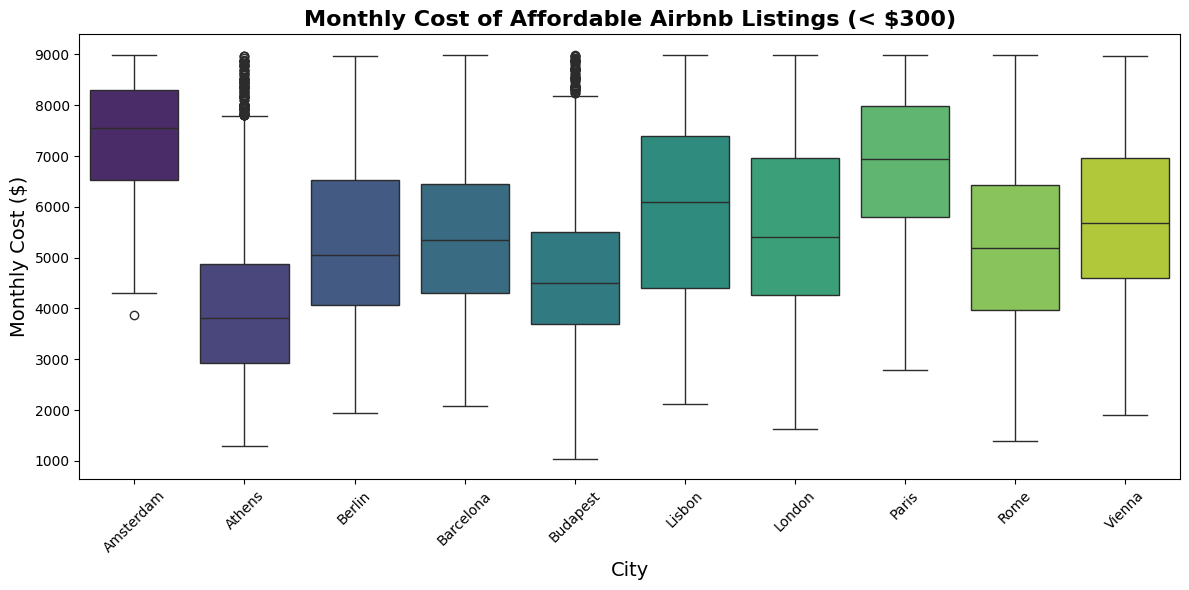

In [189]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=affordable_listings, x='city', y='monthly_cost', palette='viridis')
plt.title("Monthly Cost of Affordable Airbnb Listings (< $300)", fontsize=16, fontweight='bold')
plt.xlabel("City", fontsize=14)
plt.ylabel("Monthly Cost ($)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

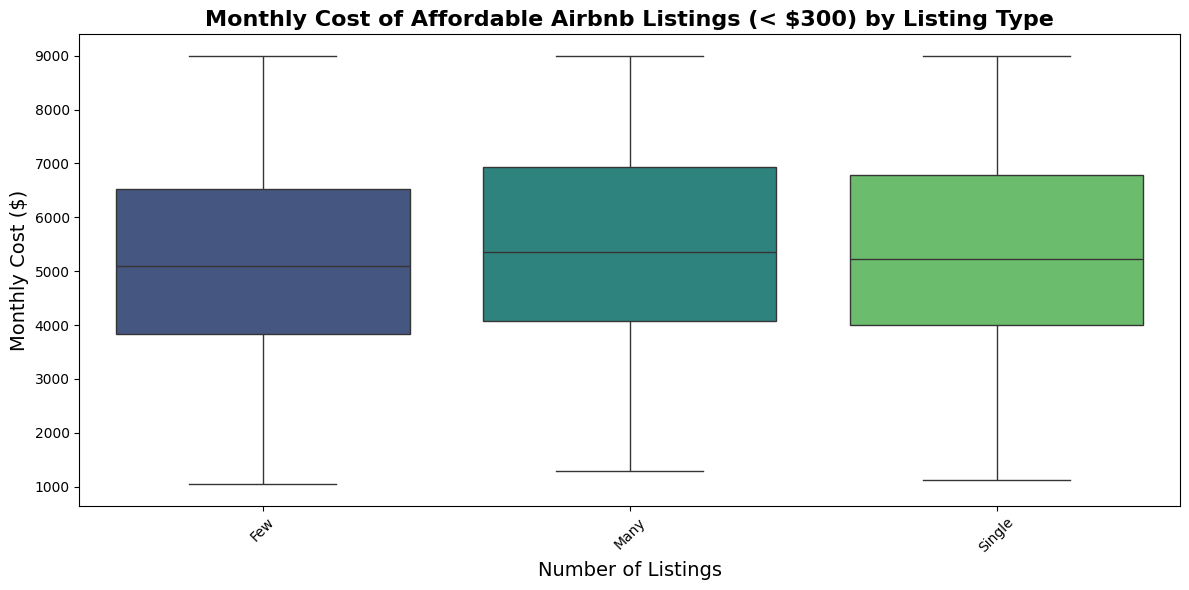

In [190]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=affordable_listings, x='listing_num', y='monthly_cost', palette='viridis')
plt.title("Monthly Cost of Affordable Airbnb Listings (< $300) by Listing Type", fontsize=16, fontweight='bold')
plt.xlabel("Number of Listings", fontsize=14)
plt.ylabel("Monthly Cost ($)", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Missing Information for Better Analysis

To better understand the phenomenon of gentrification through Airbnb data, consider the following missing information:
* Long-term Rental Prices: Average long-term rental prices in each city would provide context for Airbnb pricing and help identify areas that are becoming more expensive.
* Demographic Data: Information on the demographics of the neighborhoods affected by Airbnb, such as income levels, age distribution, and housing stock changes, would help understand who is being displaced.
* Duration of Listings: Data on how long properties have been listed on Airbnb would indicate the turnover of hosts and if properties are being used for short-term rentals as a business.
* Neighborhood Changes: Historical data regarding changes in neighborhood characteristics over time, including crime rates, local business closures, and development projects, would enhance insights into gentrification patterns.
* Occupancy Rates: Understanding how frequently properties are booked could provide insights into demand and rental market saturation.